<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#하이퍼파라미터-세팅-및-seed-고정" data-toc-modified-id="하이퍼파라미터-세팅-및-seed-고정-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>하이퍼파라미터 세팅 및 seed 고정</a></span></li><li><span><a href="#학습-데이터-EDA" data-toc-modified-id="학습-데이터-EDA-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>학습 데이터 EDA</a></span></li><li><span><a href="#데이터-전처리-함수-정의-(Dataset)" data-toc-modified-id="데이터-전처리-함수-정의-(Dataset)-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>데이터 전처리 함수 정의 (Dataset)</a></span></li><li><span><a href="#Dataset-정의-및-DataLoader-할당" data-toc-modified-id="Dataset-정의-및-DataLoader-할당-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Dataset 정의 및 DataLoader 할당</a></span><ul class="toc-item"><li><span><a href="#데이터-샘플-시각화-(Show-example-image-and-mask)" data-toc-modified-id="데이터-샘플-시각화-(Show-example-image-and-mask)-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>데이터 샘플 시각화 (Show example image and mask)</a></span></li></ul></li><li><span><a href="#baseline-model" data-toc-modified-id="baseline-model-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>baseline model</a></span><ul class="toc-item"><li><span><a href="#FCN8s-(VGG-imageNet-weight)" data-toc-modified-id="FCN8s-(VGG-imageNet-weight)-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>FCN8s (VGG imageNet weight)</a></span></li></ul></li><li><span><a href="#train,-validation,-test-함수-정의" data-toc-modified-id="train,-validation,-test-함수-정의-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>train, validation, test 함수 정의</a></span></li><li><span><a href="#모델-저장-함수-정의" data-toc-modified-id="모델-저장-함수-정의-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>모델 저장 함수 정의</a></span></li><li><span><a href="#모델-생성-및-Loss-function,-Optimizer-정의" data-toc-modified-id="모델-생성-및-Loss-function,-Optimizer-정의-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>모델 생성 및 Loss function, Optimizer 정의</a></span></li><li><span><a href="#저장된-model-불러오기-(학습된-이후)" data-toc-modified-id="저장된-model-불러오기-(학습된-이후)-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>저장된 model 불러오기 (학습된 이후)</a></span></li><li><span><a href="#submission을-위한-test-함수-정의" data-toc-modified-id="submission을-위한-test-함수-정의-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>submission을 위한 test 함수 정의</a></span></li><li><span><a href="#submission.csv-생성" data-toc-modified-id="submission.csv-생성-11"><span class="toc-item-num">11&nbsp;&nbsp;</span>submission.csv 생성</a></span></li><li><span><a href="#Reference" data-toc-modified-id="Reference-12"><span class="toc-item-num">12&nbsp;&nbsp;</span>Reference</a></span></li></ul></div>

In [1]:
!apt-get update
!apt-get install -y libsm6 libxext6 libxrender-dev
!pip install opencv-python
!pip install apex
import re
import os
import torch.nn.functional as F
import random
import time
import json
import warnings 
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from utils import label_accuracy_score
import cv2

import numpy as np
import pandas as pd

# 전처리를 위한 라이브러리
from pycocotools.coco import COCO
import torchvision
import torchvision.transforms as transforms

import albumentations as A
from albumentations.pytorch import ToTensorV2

# 시각화를 위한 라이브러리
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

plt.rcParams['axes.grid'] = False

print('pytorch version: {}'.format(torch.__version__))
print('GPU 사용 가능 여부: {}'.format(torch.cuda.is_available()))

print(torch.cuda.get_device_name(0))
print(torch.cuda.device_count())

device = "cuda" if torch.cuda.is_available() else "cpu"   # GPU 사용 가능 여부에 따라 device 정보 저장

Hit:1 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:2 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:3 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:4 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Reading package lists... Done
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libsm6 is already the newest version (2:1.2.2-1).
libxext6 is already the newest version (2:1.3.3-1).
libxrender-dev is already the newest version (1:0.9.10-1).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.
pytorch version: 1.4.0
GPU 사용 가능 여부: True
Tesla P40
1


In [2]:
class AttrDict(dict):

    IMMUTABLE = '__immutable__'

    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__[AttrDict.IMMUTABLE] = False

    def __getattr__(self, name):
        if name in self.__dict__:
            return self.__dict__[name]
        elif name in self:
            return self[name]
        else:
            raise AttributeError(name)

    def __setattr__(self, name, value):
        if not self.__dict__[AttrDict.IMMUTABLE]:
            if name in self.__dict__:
                self.__dict__[name] = value
            else:
                self[name] = value
        else:
            raise AttributeError(
                'Attempted to set "{}" to "{}", but AttrDict is immutable'.
                format(name, value)
            )

    def immutable(self, is_immutable):
        """Set immutability to is_immutable and recursively apply the setting
        to all nested AttrDicts.
        """
        self.__dict__[AttrDict.IMMUTABLE] = is_immutable
        # Recursively set immutable state
        for v in self.__dict__.values():
            if isinstance(v, AttrDict):
                v.immutable(is_immutable)
        for v in self.values():
            if isinstance(v, AttrDict):
                v.immutable(is_immutable)

    def is_immutable(self):
        return self.__dict__[AttrDict.IMMUTABLE]

__C = AttrDict()
cfg = __C
__C.GLOBAL_RANK = 0
__C.EPOCH = 0
# Absolute path to a location to keep some large files, not in this dir.
__C.ASSETS_PATH = '/opt/ml/code'

# Use class weighted loss per batch to increase loss for low pixel count classes per batch
__C.BATCH_WEIGHTING = False

# Border Relaxation Count
__C.BORDER_WINDOW = 1
# Number of epoch to use before turn off border restriction
__C.REDUCE_BORDER_EPOCH = -1
# Comma Seperated List of class id to relax
__C.STRICTBORDERCLASS = None
# Where output results get written
__C.RESULT_DIR = None

__C.OPTIONS = AttrDict()
__C.OPTIONS.TEST_MODE = False
__C.OPTIONS.INIT_DECODER = False
__C.OPTIONS.TORCH_VERSION = None

__C.TRAIN = AttrDict()
__C.TRAIN.RANDOM_BRIGHTNESS_SHIFT_VALUE = 10
__C.TRAIN.FP16 = False

#Attribute Dictionary for Dataset
__C.DATASET = AttrDict()
#Cityscapes Dir Location
__C.DATASET.CITYSCAPES_DIR = \
  os.path.join(__C.ASSETS_PATH, 'data/Cityscapes')
__C.DATASET.CITYSCAPES_CUSTOMCOARSE = \
  os.path.join(__C.ASSETS_PATH, 'data/Cityscapes/autolabelled')
__C.DATASET.CENTROID_ROOT = \
  os.path.join(__C.ASSETS_PATH, 'uniform_centroids')
#SDC Augmented Cityscapes Dir Location
__C.DATASET.CITYSCAPES_AUG_DIR = ''
#Mapillary Dataset Dir Location
__C.DATASET.MAPILLARY_DIR = os.path.join(__C.ASSETS_PATH, 'data/Mapillary/data')
#Kitti Dataset Dir Location
__C.DATASET.KITTI_DIR = ''
#SDC Augmented Kitti Dataset Dir Location
__C.DATASET.KITTI_AUG_DIR = ''
#Camvid Dataset Dir Location
__C.DATASET.CAMVID_DIR = ''
#Number of splits to support
__C.DATASET.CITYSCAPES_SPLITS = 3
__C.DATASET.MEAN = [0.485, 0.456, 0.406]
__C.DATASET.STD = [0.229, 0.224, 0.225]
__C.DATASET.NAME = ''
__C.DATASET.NUM_CLASSES = 0
__C.DATASET.IGNORE_LABEL = 255
__C.DATASET.DUMP_IMAGES = False
__C.DATASET.CLASS_UNIFORM_PCT = 0.5
__C.DATASET.CLASS_UNIFORM_TILE = 1024
__C.DATASET.COARSE_BOOST_CLASSES = None
__C.DATASET.CV = 0
__C.DATASET.COLORIZE_MASK_FN = None
__C.DATASET.CUSTOM_COARSE_PROB = None
__C.DATASET.MASK_OUT_CITYSCAPES = False

# This enables there to always be translation augmentation during random crop
# process, even if image is smaller than crop size.
__C.DATASET.TRANSLATE_AUG_FIX = False
__C.DATASET.LANCZOS_SCALES = False
# Use a center crop of size args.pre_size for mapillary validation
# Need to use this if you want to dump images
__C.DATASET.MAPILLARY_CROP_VAL = False
__C.DATASET.CROP_SIZE = '896'

__C.MODEL = AttrDict()
__C.MODEL.BN = 'regularnorm'
__C.MODEL.BNFUNC = None
__C.MODEL.MSCALE = False
__C.MODEL.THREE_SCALE = False
__C.MODEL.ALT_TWO_SCALE = False
__C.MODEL.EXTRA_SCALES = '0.5,1.5'
__C.MODEL.N_SCALES = None
__C.MODEL.ALIGN_CORNERS = False
__C.MODEL.MSCALE_LO_SCALE = 0.5
__C.MODEL.OCR_ASPP = False
__C.MODEL.SEGATTN_BOT_CH = 256
__C.MODEL.ASPP_BOT_CH = 256
__C.MODEL.MSCALE_CAT_SCALE_FLT = False
__C.MODEL.MSCALE_INNER_3x3 = True
__C.MODEL.MSCALE_DROPOUT = False
__C.MODEL.MSCALE_OLDARCH = False
__C.MODEL.MSCALE_INIT = 0.5
__C.MODEL.ATTNSCALE_BN_HEAD = False
__C.MODEL.GRAD_CKPT = False

WEIGHTS_PATH = __C.ASSETS_PATH
__C.MODEL.WRN38_CHECKPOINT = \
    os.path.join(WEIGHTS_PATH, 'wider_resnet38.pth.tar')
__C.MODEL.WRN41_CHECKPOINT = \
    os.path.join(WEIGHTS_PATH, 'wider_resnet41_cornflower_sunfish.pth')
__C.MODEL.X71_CHECKPOINT = \
    os.path.join(WEIGHTS_PATH, 'aligned_xception71.pth')
__C.MODEL.HRNET_CHECKPOINT = \
    os.path.join(WEIGHTS_PATH, 'cityscapes_trainval_ocr.HRNet_Mscale_nimble-chihuahua.pth')

__C.LOSS = AttrDict()
# Weight for OCR aux loss
__C.LOSS.OCR_ALPHA = 0.4
# Use RMI for the OCR aux loss
__C.LOSS.OCR_AUX_RMI = False
# Supervise the multi-scale predictions directly
__C.LOSS.SUPERVISED_MSCALE_WT = 0

__C.MODEL.OCR = AttrDict()
__C.MODEL.OCR.MID_CHANNELS = 512
__C.MODEL.OCR.KEY_CHANNELS = 256
__C.MODEL.OCR_EXTRA = AttrDict()
__C.MODEL.OCR_EXTRA.FINAL_CONV_KERNEL = 1
__C.MODEL.OCR_EXTRA.STAGE1 = AttrDict()
__C.MODEL.OCR_EXTRA.STAGE1.NUM_MODULES = 1
__C.MODEL.OCR_EXTRA.STAGE1.NUM_RANCHES = 1
__C.MODEL.OCR_EXTRA.STAGE1.BLOCK = 'BOTTLENECK'
__C.MODEL.OCR_EXTRA.STAGE1.NUM_BLOCKS = [4]
__C.MODEL.OCR_EXTRA.STAGE1.NUM_CHANNELS = [64]
__C.MODEL.OCR_EXTRA.STAGE1.FUSE_METHOD = 'SUM'
__C.MODEL.OCR_EXTRA.STAGE2 = AttrDict()
__C.MODEL.OCR_EXTRA.STAGE2.NUM_MODULES = 1
__C.MODEL.OCR_EXTRA.STAGE2.NUM_BRANCHES = 2
__C.MODEL.OCR_EXTRA.STAGE2.BLOCK = 'BASIC'
__C.MODEL.OCR_EXTRA.STAGE2.NUM_BLOCKS = [4, 4]
__C.MODEL.OCR_EXTRA.STAGE2.NUM_CHANNELS = [48, 96]
__C.MODEL.OCR_EXTRA.STAGE2.FUSE_METHOD = 'SUM'
__C.MODEL.OCR_EXTRA.STAGE3 = AttrDict()
__C.MODEL.OCR_EXTRA.STAGE3.NUM_MODULES = 4
__C.MODEL.OCR_EXTRA.STAGE3.NUM_BRANCHES = 3
__C.MODEL.OCR_EXTRA.STAGE3.BLOCK = 'BASIC'
__C.MODEL.OCR_EXTRA.STAGE3.NUM_BLOCKS = [4, 4, 4]
__C.MODEL.OCR_EXTRA.STAGE3.NUM_CHANNELS = [48, 96, 192]
__C.MODEL.OCR_EXTRA.STAGE3.FUSE_METHOD = 'SUM'
__C.MODEL.OCR_EXTRA.STAGE4 = AttrDict()
__C.MODEL.OCR_EXTRA.STAGE4.NUM_MODULES = 3
__C.MODEL.OCR_EXTRA.STAGE4.NUM_BRANCHES = 4
__C.MODEL.OCR_EXTRA.STAGE4.BLOCK = 'BASIC'
__C.MODEL.OCR_EXTRA.STAGE4.NUM_BLOCKS = [4, 4, 4, 4]
__C.MODEL.OCR_EXTRA.STAGE4.NUM_CHANNELS = [48, 96, 192, 384]
__C.MODEL.OCR_EXTRA.STAGE4.FUSE_METHOD = 'SUM'


def torch_version_float():
    version_str = torch.__version__
    version_re = re.search(r'^([0-9]+\.[0-9]+)', version_str)
    if version_re:
        version = float(version_re.group(1))
        logx.msg(f'Torch version: {version}, {version_str}')
    else:
        version = 1.0
        logx.msg(f'Can\'t parse torch version ({version}), assuming {version}')
    return version


def assert_and_infer_cfg(args, make_immutable=True, train_mode=True):
    """Call this function in your script after you have finished setting all cfg
    values that are necessary (e.g., merging a config from a file, merging
    command line config options, etc.). By default, this function will also
    mark the global cfg as immutable to prevent changing the global cfg
    settings during script execution (which can lead to hard to debug errors
    or code that's harder to understand than is necessary).
    """

    __C.OPTIONS.TORCH_VERSION = 1.6

    if hasattr(args, 'syncbn') and args.syncbn:
        if args.apex:
            import apex
            __C.MODEL.BN = 'apex-syncnorm'
            __C.MODEL.BNFUNC = apex.parallel.SyncBatchNorm
        else:
            raise Exception('No Support for SyncBN without Apex')
    else:
        __C.MODEL.BNFUNC = torch.nn.BatchNorm2d
        print('Using regular batch norm')

    if not train_mode:
        cfg.immutable(True)
        return

    if args.batch_weighting:
        __C.BATCH_WEIGHTING = True

    if args.custom_coarse_prob:
        __C.DATASET.CUSTOM_COARSE_PROB = args.custom_coarse_prob

    if args.jointwtborder:
        if args.strict_bdr_cls != '':
            strict_classes = [int(i) for i in args.strict_bdr_cls.split(",")]
            __C.STRICTBORDERCLASS = strict_classes
        if args.rlx_off_epoch > -1:
            __C.REDUCE_BORDER_EPOCH = args.rlx_off_epoch

    cfg.DATASET.NAME = args.dataset
    cfg.DATASET.DUMP_IMAGES = args.dump_augmentation_images

    cfg.DATASET.CLASS_UNIFORM_PCT = args.class_uniform_pct
    cfg.DATASET.CLASS_UNIFORM_TILE = args.class_uniform_tile
    if args.coarse_boost_classes:
        cfg.DATASET.COARSE_BOOST_CLASSES = \
            [int(i) for i in args.coarse_boost_classes.split(',')]

    cfg.DATASET.CLASS_UNIFORM_BIAS = None

    if args.dump_assets and args.dataset == 'cityscapes':
        # A hacky way to force that when we dump cityscapes
        logx.msg('*' * 70)
        logx.msg(f'ALERT: forcing cv=3 to allow all images to be evaluated')
        logx.msg('*' * 70)
        cfg.DATASET.CV = 3
    else:
        cfg.DATASET.CV = args.cv
    # Total number of splits
    cfg.DATASET.CV_SPLITS = 3

    if args.translate_aug_fix:
        cfg.DATASET.TRANSLATE_AUG_FIX = True

    cfg.MODEL.MSCALE = ('mscale' in args.arch.lower() or 'attnscale' in
                        args.arch.lower())

    if args.three_scale:
        cfg.MODEL.THREE_SCALE = True

    if args.alt_two_scale:
        cfg.MODEL.ALT_TWO_SCALE = True

    cfg.MODEL.MSCALE_LO_SCALE = args.mscale_lo_scale

    def str2list(s):
        alist = s.split(',')
        alist = [float(x) for x in alist]
        return alist

    if args.n_scales:
        cfg.MODEL.N_SCALES = str2list(args.n_scales)
        logx.msg('n scales {}'.format(cfg.MODEL.N_SCALES))

    if args.extra_scales:
        cfg.MODEL.EXTRA_SCALES = str2list(args.extra_scales)

    if args.align_corners:
        cfg.MODEL.ALIGN_CORNERS = True

    if args.init_decoder:
        cfg.OPTIONS.INIT_DECODER = True

    cfg.RESULT_DIR = args.result_dir

    if args.mask_out_cityscapes:
        cfg.DATASET.MASK_OUT_CITYSCAPES = True

    if args.fp16:
        cfg.TRAIN.FP16 = True

    if args.map_crop_val:
        __C.DATASET.MAPILLARY_CROP_VAL = True

    __C.DATASET.CROP_SIZE = args.crop_size

    if args.aspp_bot_ch is not None:
        # todo fixme: make all code use this cfg
        __C.MODEL.ASPP_BOT_CH = int(args.aspp_bot_ch)

    if args.mscale_cat_scale_flt:
        __C.MODEL.MSCALE_CAT_SCALE_FLT = True

    if args.mscale_no3x3:
        __C.MODEL.MSCALE_INNER_3x3 = False

    if args.mscale_dropout:
        __C.MODEL.MSCALE_DROPOUT = True

    if args.mscale_old_arch:
        __C.MODEL.MSCALE_OLDARCH = True

    if args.mscale_init is not None:
        __C.MODEL.MSCALE_INIT = args.mscale_init

    if args.attnscale_bn_head:
        __C.MODEL.ATTNSCALE_BN_HEAD = True

    if args.segattn_bot_ch is not None:
        __C.MODEL.SEGATTN_BOT_CH = args.segattn_bot_ch

    if args.set_cityscapes_root is not None:
        # '/data/cs_imgs_cv0'
        # '/data/cs_imgs_cv2'
        __C.DATASET.CITYSCAPES_DIR = args.set_cityscapes_root

    if args.ocr_alpha is not None:
        __C.LOSS.OCR_ALPHA = args.ocr_alpha

    if args.ocr_aux_loss_rmi:
        __C.LOSS.OCR_AUX_RMI = True

    if args.supervised_mscale_loss_wt is not None:
        __C.LOSS.SUPERVISED_MSCALE_WT = args.supervised_mscale_loss_wt

    cfg.DROPOUT_COARSE_BOOST_CLASSES = None
    if args.custom_coarse_dropout_classes:
        cfg.DROPOUT_COARSE_BOOST_CLASSES = \
            [int(i) for i in args.custom_coarse_dropout_classes.split(',')]

    if args.grad_ckpt:
        __C.MODEL.GRAD_CKPT = True

    __C.GLOBAL_RANK = args.global_rank

    if make_immutable:
        cfg.immutable(True)


def update_epoch(epoch):
    # Update EPOCH CTR
    cfg.immutable(False)
    cfg.EPOCH = epoch
    cfg.immutable(True)


def update_dataset_cfg(num_classes, ignore_label):
    cfg.immutable(False)
    cfg.DATASET.NUM_CLASSES = num_classes
    cfg.DATASET.IGNORE_LABEL = ignore_label
    logx.msg('num_classes = {}'.format(num_classes))
    cfg.immutable(True)


def update_dataset_inst(dataset_inst):
    cfg.immutable(False)
    cfg.DATASET_INST = dataset_inst
    cfg.immutable(True)
    
align_corners = cfg.MODEL.ALIGN_CORNERS


def Norm2d(in_channels, **kwargs):
    """
    Custom Norm Function to allow flexible switching
    """
    normalization_layer = nn.BatchNorm2d(in_channels)
    return normalization_layer


def initialize_weights(*models):
    """
    Initialize Model Weights
    """
    for model in models:
        for module in model.modules():
            if isinstance(module, (nn.Conv2d, nn.Linear)):
                nn.init.kaiming_normal_(module.weight)
                if module.bias is not None:
                    module.bias.data.zero_()
            elif isinstance(module, cfg.MODEL.BNFUNC):
                module.weight.data.fill_(1)
                module.bias.data.zero_()


#@amp.float_function
def Upsample(x, size):
    """
    Wrapper Around the Upsample Call
    """
    return nn.functional.interpolate(x, size=size, mode='bilinear',
                                     align_corners=align_corners)


#@amp.float_function
def Upsample2(x):
    """
    Wrapper Around the Upsample Call
    """
    return nn.functional.interpolate(x, scale_factor=2, mode='bilinear',
                                     align_corners=align_corners)


def Down2x(x):
    return torch.nn.functional.interpolate(
        x, scale_factor=0.5, mode='bilinear', align_corners=align_corners)


def Up15x(x):
    return torch.nn.functional.interpolate(
        x, scale_factor=1.5, mode='bilinear', align_corners=align_corners)


def scale_as(x, y):
    '''
    scale x to the same size as y
    '''
    y_size = y.size(2), y.size(3)

    if False:
        x_scaled = torch.nn.functional.interpolate(
            x, size=y_size, mode='bilinear',
            align_corners=align_corners)
    else:
        x_scaled = torch.nn.functional.interpolate(
            x, size=y_size, mode='bilinear',
            align_corners=align_corners)
    return x_scaled


def DownX(x, scale_factor):
    '''
    scale x to the same size as y
    '''
    if False:
        x_scaled = torch.nn.functional.interpolate(
            x, scale_factor=scale_factor, mode='bilinear',
            align_corners=align_corners, recompute_scale_factor=True)
    else:
        x_scaled = torch.nn.functional.interpolate(
            x, scale_factor=scale_factor, mode='bilinear',
            align_corners=align_corners)
    return x_scaled


def ResizeX(x, scale_factor):
    '''
    scale x by some factor
    '''
    if False:
        x_scaled = torch.nn.functional.interpolate(
            x, scale_factor=scale_factor, mode='bilinear',
            align_corners=align_corners, recompute_scale_factor=True)
    else:
        x_scaled = torch.nn.functional.interpolate(
            x, scale_factor=scale_factor, mode='bilinear',
            align_corners=align_corners)
    return x_scaled

BN_MOMENTUM = 0.1
align_corners = cfg.MODEL.ALIGN_CORNERS
relu_inplace = True


def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = Norm2d(planes, momentum=BN_MOMENTUM)
        self.relu = nn.ReLU(inplace=relu_inplace)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = Norm2d(planes, momentum=BN_MOMENTUM)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out = out + residual
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = Norm2d(planes, momentum=BN_MOMENTUM)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = Norm2d(planes, momentum=BN_MOMENTUM)
        self.conv3 = nn.Conv2d(planes, planes * self.expansion, kernel_size=1,
                               bias=False)
        self.bn3 = Norm2d(planes * self.expansion, momentum=BN_MOMENTUM)
        self.relu = nn.ReLU(inplace=relu_inplace)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out = out + residual
        out = self.relu(out)

        return out


class HighResolutionModule(nn.Module):
    def __init__(self, num_branches, blocks, num_blocks, num_inchannels,
                 num_channels, fuse_method, multi_scale_output=True):
        super(HighResolutionModule, self).__init__()
        self._check_branches(
            num_branches, blocks, num_blocks, num_inchannels, num_channels)

        self.num_inchannels = num_inchannels
        self.fuse_method = fuse_method
        self.num_branches = num_branches

        self.multi_scale_output = multi_scale_output

        self.branches = self._make_branches(
            num_branches, blocks, num_blocks, num_channels)
        self.fuse_layers = self._make_fuse_layers()
        self.relu = nn.ReLU(inplace=relu_inplace)

    def _check_branches(self, num_branches, blocks, num_blocks,
                        num_inchannels, num_channels):
        if num_branches != len(num_blocks):
            error_msg = 'NUM_BRANCHES({}) <> NUM_BLOCKS({})'.format(
                num_branches, len(num_blocks))

            raise ValueError(error_msg)

        if num_branches != len(num_channels):
            error_msg = 'NUM_BRANCHES({}) <> NUM_CHANNELS({})'.format(
                num_branches, len(num_channels))

            raise ValueError(error_msg)

        if num_branches != len(num_inchannels):
            error_msg = 'NUM_BRANCHES({}) <> NUM_INCHANNELS({})'.format(
                num_branches, len(num_inchannels))

            raise ValueError(error_msg)

    def _make_one_branch(self, branch_index, block, num_blocks, num_channels,
                         stride=1):
        downsample = None
        if stride != 1 or \
           self.num_inchannels[branch_index] != (num_channels[branch_index] *
                                                 block.expansion):
            downsample = nn.Sequential(
                nn.Conv2d(self.num_inchannels[branch_index],
                          num_channels[branch_index] * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                Norm2d(num_channels[branch_index] * block.expansion,
                       momentum=BN_MOMENTUM),
            )

        layers = []
        layers.append(block(self.num_inchannels[branch_index],
                            num_channels[branch_index], stride, downsample))
        self.num_inchannels[branch_index] = \
            num_channels[branch_index] * block.expansion
        for i in range(1, num_blocks[branch_index]):
            layers.append(block(self.num_inchannels[branch_index],
                                num_channels[branch_index]))

        return nn.Sequential(*layers)

    def _make_branches(self, num_branches, block, num_blocks, num_channels):
        branches = []

        for i in range(num_branches):
            branches.append(
                self._make_one_branch(i, block, num_blocks, num_channels))

        return nn.ModuleList(branches)

    def _make_fuse_layers(self):
        if self.num_branches == 1:
            return None

        num_branches = self.num_branches
        num_inchannels = self.num_inchannels
        fuse_layers = []
        for i in range(num_branches if self.multi_scale_output else 1):
            fuse_layer = []
            for j in range(num_branches):
                if j > i:
                    fuse_layer.append(nn.Sequential(
                        nn.Conv2d(num_inchannels[j],
                                  num_inchannels[i],
                                  1,
                                  1,
                                  0,
                                  bias=False),
                        Norm2d(num_inchannels[i], momentum=BN_MOMENTUM)))
                elif j == i:
                    fuse_layer.append(None)
                else:
                    conv3x3s = []
                    for k in range(i-j):
                        if k == i - j - 1:
                            num_outchannels_conv3x3 = num_inchannels[i]
                            conv3x3s.append(nn.Sequential(
                                nn.Conv2d(num_inchannels[j],
                                          num_outchannels_conv3x3,
                                          3, 2, 1, bias=False),
                                Norm2d(num_outchannels_conv3x3,
                                       momentum=BN_MOMENTUM)))
                        else:
                            num_outchannels_conv3x3 = num_inchannels[j]
                            conv3x3s.append(nn.Sequential(
                                nn.Conv2d(num_inchannels[j],
                                          num_outchannels_conv3x3,
                                          3, 2, 1, bias=False),
                                Norm2d(num_outchannels_conv3x3,
                                       momentum=BN_MOMENTUM),
                                nn.ReLU(inplace=relu_inplace)))
                    fuse_layer.append(nn.Sequential(*conv3x3s))
            fuse_layers.append(nn.ModuleList(fuse_layer))

        return nn.ModuleList(fuse_layers)

    def get_num_inchannels(self):
        return self.num_inchannels

    def forward(self, x):
        if self.num_branches == 1:
            return [self.branches[0](x[0])]

        for i in range(self.num_branches):
            x[i] = self.branches[i](x[i])

        x_fuse = []
        for i in range(len(self.fuse_layers)):
            y = x[0] if i == 0 else self.fuse_layers[i][0](x[0])
            for j in range(1, self.num_branches):
                if i == j:
                    y = y + x[j]
                elif j > i:
                    width_output = x[i].shape[-1]
                    height_output = x[i].shape[-2]
                    y = y + F.interpolate(
                        self.fuse_layers[i][j](x[j]),
                        size=[height_output, width_output],
                        mode='bilinear', align_corners=align_corners)
                else:
                    y = y + self.fuse_layers[i][j](x[j])
            x_fuse.append(self.relu(y))

        return x_fuse


blocks_dict = {
    'BASIC': BasicBlock,
    'BOTTLENECK': Bottleneck
}


class HighResolutionNet(nn.Module):

    def __init__(self, **kwargs):
        extra = cfg.MODEL.OCR_EXTRA
        super(HighResolutionNet, self).__init__()

        # stem net
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1,
                               bias=False)
        self.bn1 = Norm2d(64, momentum=BN_MOMENTUM)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1,
                               bias=False)
        self.bn2 = Norm2d(64, momentum=BN_MOMENTUM)
        self.relu = nn.ReLU(inplace=relu_inplace)

        self.stage1_cfg = extra['STAGE1']
        num_channels = self.stage1_cfg['NUM_CHANNELS'][0]
        block = blocks_dict[self.stage1_cfg['BLOCK']]
        num_blocks = self.stage1_cfg['NUM_BLOCKS'][0]
        self.layer1 = self._make_layer(block, 64, num_channels, num_blocks)
        stage1_out_channel = block.expansion*num_channels

        self.stage2_cfg = extra['STAGE2']
        num_channels = self.stage2_cfg['NUM_CHANNELS']
        block = blocks_dict[self.stage2_cfg['BLOCK']]
        num_channels = [num_channels[i] * block.expansion
                        for i in range(len(num_channels))]
        self.transition1 = self._make_transition_layer(
            [stage1_out_channel], num_channels)
        self.stage2, pre_stage_channels = self._make_stage(
            self.stage2_cfg, num_channels)

        self.stage3_cfg = extra['STAGE3']
        num_channels = self.stage3_cfg['NUM_CHANNELS']
        block = blocks_dict[self.stage3_cfg['BLOCK']]
        num_channels = [num_channels[i] * block.expansion
                        for i in range(len(num_channels))]
        self.transition2 = self._make_transition_layer(
            pre_stage_channels, num_channels)
        self.stage3, pre_stage_channels = self._make_stage(
            self.stage3_cfg, num_channels)

        self.stage4_cfg = extra['STAGE4']
        num_channels = self.stage4_cfg['NUM_CHANNELS']
        block = blocks_dict[self.stage4_cfg['BLOCK']]
        num_channels = [num_channels[i] * block.expansion
                        for i in range(len(num_channels))]
        self.transition3 = self._make_transition_layer(
            pre_stage_channels, num_channels)
        self.stage4, pre_stage_channels = self._make_stage(
            self.stage4_cfg, num_channels, multi_scale_output=True)

        self.high_level_ch = np.int(np.sum(pre_stage_channels))

    def _make_transition_layer(
            self, num_channels_pre_layer, num_channels_cur_layer):
        num_branches_cur = len(num_channels_cur_layer)
        num_branches_pre = len(num_channels_pre_layer)

        transition_layers = []
        for i in range(num_branches_cur):
            if i < num_branches_pre:
                if num_channels_cur_layer[i] != num_channels_pre_layer[i]:
                    transition_layers.append(nn.Sequential(
                        nn.Conv2d(num_channels_pre_layer[i],
                                  num_channels_cur_layer[i],
                                  3,
                                  1,
                                  1,
                                  bias=False),
                        Norm2d(
                            num_channels_cur_layer[i], momentum=BN_MOMENTUM),
                        nn.ReLU(inplace=relu_inplace)))
                else:
                    transition_layers.append(None)
            else:
                conv3x3s = []
                for j in range(i+1-num_branches_pre):
                    inchannels = num_channels_pre_layer[-1]
                    outchannels = num_channels_cur_layer[i] \
                        if j == i-num_branches_pre else inchannels
                    conv3x3s.append(nn.Sequential(
                        nn.Conv2d(
                            inchannels, outchannels, 3, 2, 1, bias=False),
                        Norm2d(outchannels, momentum=BN_MOMENTUM),
                        nn.ReLU(inplace=relu_inplace)))
                transition_layers.append(nn.Sequential(*conv3x3s))

        return nn.ModuleList(transition_layers)

    def _make_layer(self, block, inplanes, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                Norm2d(planes * block.expansion, momentum=BN_MOMENTUM),
            )

        layers = []
        layers.append(block(inplanes, planes, stride, downsample))
        inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(inplanes, planes))

        return nn.Sequential(*layers)

    def _make_stage(self, layer_config, num_inchannels,
                    multi_scale_output=True):
        num_modules = layer_config['NUM_MODULES']
        num_branches = layer_config['NUM_BRANCHES']
        num_blocks = layer_config['NUM_BLOCKS']
        num_channels = layer_config['NUM_CHANNELS']
        block = blocks_dict[layer_config['BLOCK']]
        fuse_method = layer_config['FUSE_METHOD']

        modules = []
        for i in range(num_modules):
            # multi_scale_output is only used last module
            if not multi_scale_output and i == num_modules - 1:
                reset_multi_scale_output = False
            else:
                reset_multi_scale_output = True
            modules.append(
                HighResolutionModule(num_branches,
                                     block,
                                     num_blocks,
                                     num_inchannels,
                                     num_channels,
                                     fuse_method,
                                     reset_multi_scale_output)
            )
            num_inchannels = modules[-1].get_num_inchannels()

        return nn.Sequential(*modules), num_inchannels

    def forward(self, x_in):
        x = self.conv1(x_in)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.layer1(x)

        x_list = []
        for i in range(self.stage2_cfg['NUM_BRANCHES']):
            if self.transition1[i] is not None:
                x_list.append(self.transition1[i](x))
            else:
                x_list.append(x)
        y_list = self.stage2(x_list)

        x_list = []
        for i in range(self.stage3_cfg['NUM_BRANCHES']):
            if self.transition2[i] is not None:
                if i < self.stage2_cfg['NUM_BRANCHES']:
                    x_list.append(self.transition2[i](y_list[i]))
                else:
                    x_list.append(self.transition2[i](y_list[-1]))
            else:
                x_list.append(y_list[i])
        y_list = self.stage3(x_list)

        x_list = []
        for i in range(self.stage4_cfg['NUM_BRANCHES']):
            if self.transition3[i] is not None:
                if i < self.stage3_cfg['NUM_BRANCHES']:
                    x_list.append(self.transition3[i](y_list[i]))
                else:
                    x_list.append(self.transition3[i](y_list[-1]))
            else:
                x_list.append(y_list[i])
        x = self.stage4(x_list)

        # Upsampling
        x0_h, x0_w = x[0].size(2), x[0].size(3)
        x1 = F.interpolate(x[1], size=(x0_h, x0_w),
                           mode='bilinear', align_corners=align_corners)
        x2 = F.interpolate(x[2], size=(x0_h, x0_w),
                           mode='bilinear', align_corners=align_corners)
        x3 = F.interpolate(x[3], size=(x0_h, x0_w),
                           mode='bilinear', align_corners=align_corners)

        feats = torch.cat([x[0], x1, x2, x3], 1)

        return None, None, feats

    def init_weights(self, pretrained=cfg.MODEL.HRNET_CHECKPOINT):

        for name, m in self.named_modules():
            if any(part in name for part in {'cls', 'aux', 'ocr'}):
                # print('skipped', name)
                continue
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight, std=0.001)
#             else:
#                 nn.init.constant_(m.weight, 1)
#                 nn.init.constant_(m.bias, 0)
        if os.path.isfile(pretrained):
            pretrained_dict = torch.load(pretrained,
                                         map_location={'cuda:0': 'cpu'})
            model_dict = self.state_dict()
            pretrained_dict = {k.replace('last_layer',
                                         'aux_head').replace('model.', ''): v
                               for k, v in pretrained_dict.items()}
            #print(set(model_dict) - set(pretrained_dict))
            #print(set(pretrained_dict) - set(model_dict))
            pretrained_dict = {k: v for k, v in pretrained_dict.items()
                               if k in model_dict.keys()}
            model_dict.update(pretrained_dict)
            self.load_state_dict(model_dict)
        elif pretrained:
            raise RuntimeError('No such file {}'.format(pretrained))


def get_seg_model():
    model = HighResolutionNet()
    model.init_weights()

    return model

from collections import OrderedDict

class get_resnet(nn.Module):
    def __init__(self, trunk_name, output_stride=8):
        super(get_resnet, self).__init__()

        if trunk_name == 'seresnext-50':
            resnet = se_resnext50_32x4d()
        elif trunk_name == 'seresnext-101':
            resnet = se_resnext101_32x4d()
        elif trunk_name == 'resnet-50':
            resnet = resnet50()
            resnet.layer0 = nn.Sequential(resnet.conv1, resnet.bn1,
                                          resnet.relu, resnet.maxpool)
        elif trunk_name == 'resnet-101':
            resnet = resnet101()
            resnet.layer0 = nn.Sequential(resnet.conv1, resnet.bn1,
                                          resnet.relu, resnet.maxpool)
        else:
            raise ValueError("Not a valid network arch")

        self.layer0 = resnet.layer0
        self.layer1, self.layer2, self.layer3, self.layer4 = \
            resnet.layer1, resnet.layer2, resnet.layer3, resnet.layer4

        if output_stride == 8:
            for n, m in self.layer3.named_modules():
                if 'conv2' in n:
                    m.dilation, m.padding, m.stride = (2, 2), (2, 2), (1, 1)
                elif 'downsample.0' in n:
                    m.stride = (1, 1)
            for n, m in self.layer4.named_modules():
                if 'conv2' in n:
                    m.dilation, m.padding, m.stride = (4, 4), (4, 4), (1, 1)
                elif 'downsample.0' in n:
                    m.stride = (1, 1)
        elif output_stride == 16:
            for n, m in self.layer4.named_modules():
                if 'conv2' in n:
                    m.dilation, m.padding, m.stride = (2, 2), (2, 2), (1, 1)
                elif 'downsample.0' in n:
                    m.stride = (1, 1)
        else:
            raise 'unsupported output_stride {}'.format(output_stride)

    def forward(self, x):
        x = self.layer0(x)
        x = self.layer1(x)
        s2_features = x
        x = self.layer2(x)
        s4_features = x
        x = self.layer3(x)
        x = self.layer4(x)
        return s2_features, s4_features, x


def get_trunk(trunk_name, output_stride=8):
    """
    Retrieve the network trunk and channel counts.
    """
    assert output_stride == 8, 'Only stride8 supported right now'

    if trunk_name == 'wrn38':
        #
        # FIXME: pass in output_stride once we support stride 16
        #
        backbone = wrn38(pretrained=True)
        s2_ch = 128
        s4_ch = 256
        high_level_ch = 4096
    elif trunk_name == 'xception71':
        backbone = xception71(output_stride=output_stride, BatchNorm=Norm2d,
                              pretrained=True)
        s2_ch = 64
        s4_ch = 128
        high_level_ch = 2048
    elif trunk_name == 'seresnext-50' or trunk_name == 'seresnext-101':
        backbone = get_resnet(trunk_name, output_stride=output_stride)
        s2_ch = 48
        s4_ch = -1
        high_level_ch = 2048
    elif trunk_name == 'resnet-50' or trunk_name == 'resnet-101':
        backbone = get_resnet(trunk_name, output_stride=output_stride)
        s2_ch = 256
        s4_ch = -1
        high_level_ch = 2048
    elif trunk_name == 'hrnetv2':
        backbone = get_seg_model()
        high_level_ch = backbone.high_level_ch
        s2_ch = -1
        s4_ch = -1
    else:
        raise 'unknown backbone {}'.format(trunk_name)

    return backbone, s2_ch, s4_ch, high_level_ch


class ConvBnRelu(nn.Module):
    # https://github.com/lingtengqiu/Deeperlab-pytorch/blob/master/seg_opr/seg_oprs.py
    def __init__(self, in_planes, out_planes, kernel_size, stride=1, padding=0,
                 norm_layer=Norm2d):
        super(ConvBnRelu, self).__init__()
        self.conv = nn.Conv2d(in_planes, out_planes, kernel_size=kernel_size,
                              stride=stride, padding=padding, bias=False)
        self.bn = norm_layer(out_planes, eps=1e-5)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)

        return x


class AtrousSpatialPyramidPoolingModule(nn.Module):
    """
    operations performed:
      1x1 x depth
      3x3 x depth dilation 6
      3x3 x depth dilation 12
      3x3 x depth dilation 18
      image pooling
      concatenate all together
      Final 1x1 conv
    """

    def __init__(self, in_dim, reduction_dim=256, output_stride=16,
                 rates=(6, 12, 18)):
        super(AtrousSpatialPyramidPoolingModule, self).__init__()

        if output_stride == 8:
            rates = [2 * r for r in rates]
        elif output_stride == 16:
            pass
        else:
            raise 'output stride of {} not supported'.format(output_stride)

        self.features = []
        # 1x1
        self.features.append(
            nn.Sequential(nn.Conv2d(in_dim, reduction_dim, kernel_size=1,
                                    bias=False),
                          Norm2d(reduction_dim), nn.ReLU(inplace=True)))
        # other rates
        for r in rates:
            self.features.append(nn.Sequential(
                nn.Conv2d(in_dim, reduction_dim, kernel_size=3,
                          dilation=r, padding=r, bias=False),
                Norm2d(reduction_dim),
                nn.ReLU(inplace=True)
            ))
        self.features = nn.ModuleList(self.features)

        # img level features
        self.img_pooling = nn.AdaptiveAvgPool2d(1)
        self.img_conv = nn.Sequential(
            nn.Conv2d(in_dim, reduction_dim, kernel_size=1, bias=False),
            Norm2d(reduction_dim), nn.ReLU(inplace=True))

    def forward(self, x):
        x_size = x.size()

        img_features = self.img_pooling(x)
        img_features = self.img_conv(img_features)
        img_features = Upsample(img_features, x_size[2:])
        out = img_features

        for f in self.features:
            y = f(x)
            out = torch.cat((out, y), 1)
        return out


class ASPP_edge(AtrousSpatialPyramidPoolingModule):
    def __init__(self, in_dim, reduction_dim=256, output_stride=16,
                 rates=(6, 12, 18)):
        super(ASPP_edge, self).__init__(in_dim=in_dim,
                                        reduction_dim=reduction_dim,
                                        output_stride=output_stride,
                                        rates=rates)
        self.edge_conv = nn.Sequential(
            nn.Conv2d(1, reduction_dim, kernel_size=1, bias=False),
            Norm2d(reduction_dim), nn.ReLU(inplace=True))

    def forward(self, x, edge):
        x_size = x.size()

        img_features = self.img_pooling(x)
        img_features = self.img_conv(img_features)
        img_features = Upsample(img_features, x_size[2:])
        out = img_features
        edge_features = Upsample(edge, x_size[2:])
        edge_features = self.edge_conv(edge_features)
        out = torch.cat((out, edge_features), 1)

        for f in self.features:
            y = f(x)
            out = torch.cat((out, y), 1)
        return out


def dpc_conv(in_dim, reduction_dim, dil, separable):
    if separable:
        groups = reduction_dim
    else:
        groups = 1

    return nn.Sequential(
        nn.Conv2d(in_dim, reduction_dim, kernel_size=3, dilation=dil,
                  padding=dil, bias=False, groups=groups),
        nn.BatchNorm2d(reduction_dim),
        nn.ReLU(inplace=True)
    )


class DPC(nn.Module):
    '''
    From: Searching for Efficient Multi-scale architectures for dense
    prediction
    '''
    def __init__(self, in_dim, reduction_dim=256, output_stride=16,
                 rates=[(1, 6), (18, 15), (6, 21), (1, 1), (6, 3)],
                 dropout=False, separable=False):
        super(DPC, self).__init__()

        self.dropout = dropout
        if output_stride == 8:
            rates = [(2 * r[0], 2 * r[1]) for r in rates]
        elif output_stride == 16:
            pass
        else:
            raise 'output stride of {} not supported'.format(output_stride)

        self.a = dpc_conv(in_dim, reduction_dim, rates[0], separable)
        self.b = dpc_conv(reduction_dim, reduction_dim, rates[1], separable)
        self.c = dpc_conv(reduction_dim, reduction_dim, rates[2], separable)
        self.d = dpc_conv(reduction_dim, reduction_dim, rates[3], separable)
        self.e = dpc_conv(reduction_dim, reduction_dim, rates[4], separable)

        self.drop = nn.Dropout(p=0.1)

    def forward(self, x):
        a = self.a(x)
        b = self.b(a)
        c = self.c(a)
        d = self.d(a)
        e = self.e(b)
        out = torch.cat((a, b, c, d, e), 1)
        if self.dropout:
            out = self.drop(out)
        return out


def get_aspp(high_level_ch, bottleneck_ch, output_stride, dpc=False):
    """
    Create aspp block
    """
    if dpc:
        aspp = DPC(high_level_ch, bottleneck_ch, output_stride=output_stride)
    else:
        aspp = AtrousSpatialPyramidPoolingModule(high_level_ch, bottleneck_ch,
                                                 output_stride=output_stride)
    aspp_out_ch = 5 * bottleneck_ch
    return aspp, aspp_out_ch


def BNReLU(ch):
    return nn.Sequential(
        Norm2d(ch),
        nn.ReLU())


def make_seg_head(in_ch, out_ch):
    bot_ch = cfg.MODEL.SEGATTN_BOT_CH
    return nn.Sequential(
        nn.Conv2d(in_ch, bot_ch, kernel_size=3, padding=1, bias=False),
        Norm2d(bot_ch),
        nn.ReLU(inplace=True),
        nn.Conv2d(bot_ch, bot_ch, kernel_size=3, padding=1, bias=False),
        Norm2d(bot_ch),
        nn.ReLU(inplace=True),
        nn.Conv2d(bot_ch, out_ch, kernel_size=1, bias=False))


def init_attn(m):
    for module in m.modules():
        if isinstance(module, (nn.Conv2d, nn.Linear)):
            nn.init.zeros_(module.weight)
            if module.bias is not None:
                nn.init.constant_(module.bias, 0.5)
        elif isinstance(module, cfg.MODEL.BNFUNC):
            module.weight.data.fill_(1)
            module.bias.data.zero_()


def make_attn_head(in_ch, out_ch):
    bot_ch = cfg.MODEL.SEGATTN_BOT_CH
    if cfg.MODEL.MSCALE_OLDARCH:
        return old_make_attn_head(in_ch, bot_ch, out_ch)

    od = OrderedDict([('conv0', nn.Conv2d(in_ch, bot_ch, kernel_size=3,
                                          padding=1, bias=False)),
                      ('bn0', Norm2d(bot_ch)),
                      ('re0', nn.ReLU(inplace=True))])

    if cfg.MODEL.MSCALE_INNER_3x3:
        od['conv1'] = nn.Conv2d(bot_ch, bot_ch, kernel_size=3, padding=1,
                                bias=False)
        od['bn1'] = Norm2d(bot_ch)
        od['re1'] = nn.ReLU(inplace=True)

    if cfg.MODEL.MSCALE_DROPOUT:
        od['drop'] = nn.Dropout(0.5)

    od['conv2'] = nn.Conv2d(bot_ch, out_ch, kernel_size=1, bias=False)
    od['sig'] = nn.Sigmoid()

    attn_head = nn.Sequential(od)
    # init_attn(attn_head)
    return attn_head


def old_make_attn_head(in_ch, bot_ch, out_ch):
    attn = nn.Sequential(
        nn.Conv2d(in_ch, bot_ch, kernel_size=3, padding=1, bias=False),
        Norm2d(bot_ch),
        nn.ReLU(inplace=True),
        nn.Conv2d(bot_ch, bot_ch, kernel_size=3, padding=1, bias=False),
        Norm2d(bot_ch),
        nn.ReLU(inplace=True),
        nn.Conv2d(bot_ch, out_ch, kernel_size=out_ch, bias=False),
        nn.Sigmoid())

    init_attn(attn)
    return attn

class SpatialGather_Module(nn.Module):
    """
        Aggregate the context features according to the initial
        predicted probability distribution.
        Employ the soft-weighted method to aggregate the context.
        Output:
          The correlation of every class map with every feature map
          shape = [n, num_feats, num_classes, 1]
    """
    def __init__(self, cls_num=0, scale=1):
        super(SpatialGather_Module, self).__init__()
        self.cls_num = cls_num
        self.scale = scale

    def forward(self, feats, probs):
        batch_size, c, _, _ = probs.size(0), probs.size(1), probs.size(2), \
            probs.size(3)

        # each class image now a vector
        probs = probs.view(batch_size, c, -1)
        feats = feats.view(batch_size, feats.size(1), -1)

        feats = feats.permute(0, 2, 1)  # batch x hw x c
        probs = F.softmax(self.scale * probs, dim=2)  # batch x k x hw
        ocr_context = torch.matmul(probs, feats)
        ocr_context = ocr_context.permute(0, 2, 1).unsqueeze(3)
        return ocr_context


class ObjectAttentionBlock(nn.Module):
    '''
    The basic implementation for object context block
    Input:
        N X C X H X W
    Parameters:
        in_channels       : the dimension of the input feature map
        key_channels      : the dimension after the key/query transform
        scale             : choose the scale to downsample the input feature
                            maps (save memory cost)
    Return:
        N X C X H X W
    '''
    def __init__(self, in_channels, key_channels, scale=1):
        super(ObjectAttentionBlock, self).__init__()
        self.scale = scale
        self.in_channels = in_channels
        self.key_channels = key_channels
        self.pool = nn.MaxPool2d(kernel_size=(scale, scale))
        self.f_pixel = nn.Sequential(
            nn.Conv2d(in_channels=self.in_channels, out_channels=self.key_channels,
                      kernel_size=1, stride=1, padding=0, bias=False),
            BNReLU(self.key_channels),
            nn.Conv2d(in_channels=self.key_channels, out_channels=self.key_channels,
                      kernel_size=1, stride=1, padding=0, bias=False),
            BNReLU(self.key_channels),
        )
        self.f_object = nn.Sequential(
            nn.Conv2d(in_channels=self.in_channels, out_channels=self.key_channels,
                      kernel_size=1, stride=1, padding=0, bias=False),
            BNReLU(self.key_channels),
            nn.Conv2d(in_channels=self.key_channels, out_channels=self.key_channels,
                      kernel_size=1, stride=1, padding=0, bias=False),
            BNReLU(self.key_channels),
        )
        self.f_down = nn.Sequential(
            nn.Conv2d(in_channels=self.in_channels, out_channels=self.key_channels,
                      kernel_size=1, stride=1, padding=0, bias=False),
            BNReLU(self.key_channels),
        )
        self.f_up = nn.Sequential(
            nn.Conv2d(in_channels=self.key_channels, out_channels=self.in_channels,
                      kernel_size=1, stride=1, padding=0, bias=False),
            BNReLU(self.in_channels),
        )

    def forward(self, x, proxy):
        batch_size, h, w = x.size(0), x.size(2), x.size(3)
        if self.scale > 1:
            x = self.pool(x)

        query = self.f_pixel(x).view(batch_size, self.key_channels, -1)
        query = query.permute(0, 2, 1)
        key = self.f_object(proxy).view(batch_size, self.key_channels, -1)
        value = self.f_down(proxy).view(batch_size, self.key_channels, -1)
        value = value.permute(0, 2, 1)

        sim_map = torch.matmul(query, key)
        sim_map = (self.key_channels**-.5) * sim_map
        sim_map = F.softmax(sim_map, dim=-1)

        # add bg context ...
        context = torch.matmul(sim_map, value)
        context = context.permute(0, 2, 1).contiguous()
        context = context.view(batch_size, self.key_channels, *x.size()[2:])
        context = self.f_up(context)
        if self.scale > 1:
            context = F.interpolate(input=context, size=(h, w), mode='bilinear',
                                    align_corners=cfg.MODEL.ALIGN_CORNERS)

        return context


class SpatialOCR_Module(nn.Module):
    """
    Implementation of the OCR module:
    We aggregate the global object representation to update the representation
    for each pixel.
    """
    def __init__(self, in_channels, key_channels, out_channels, scale=1,
                 dropout=0.1):
        super(SpatialOCR_Module, self).__init__()
        self.object_context_block = ObjectAttentionBlock(in_channels,
                                                         key_channels,
                                                         scale)
        if cfg.MODEL.OCR_ASPP:
            self.aspp, aspp_out_ch = get_aspp(
                in_channels, bottleneck_ch=cfg.MODEL.ASPP_BOT_CH,
                output_stride=8)
            _in_channels = 2 * in_channels + aspp_out_ch
        else:
            _in_channels = 2 * in_channels

        self.conv_bn_dropout = nn.Sequential(
            nn.Conv2d(_in_channels, out_channels, kernel_size=1, padding=0,
                      bias=False),
            BNReLU(out_channels),
            nn.Dropout2d(dropout)
        )

    def forward(self, feats, proxy_feats):
        context = self.object_context_block(feats, proxy_feats)

        if cfg.MODEL.OCR_ASPP:
            aspp = self.aspp(feats)
            output = self.conv_bn_dropout(torch.cat([context, aspp, feats], 1))
        else:
            output = self.conv_bn_dropout(torch.cat([context, feats], 1))

        return output

def fmt_scale(prefix, scale):
    """
    format scale name
    :prefix: a string that is the beginning of the field name
    :scale: a scale value (0.25, 0.5, 1.0, 2.0)
    """

    scale_str = str(float(scale))
    scale_str.replace('.', '')
    return f'{prefix}_{scale_str}x'


class OCR_block(nn.Module):
    """
    Some of the code in this class is borrowed from:
    https://github.com/HRNet/HRNet-Semantic-Segmentation/tree/HRNet-OCR
    """
    def __init__(self, high_level_ch):
        super(OCR_block, self).__init__()

        ocr_mid_channels = cfg.MODEL.OCR.MID_CHANNELS

        ocr_key_channels = cfg.MODEL.OCR.KEY_CHANNELS
        num_classes = 12

        self.conv3x3_ocr = nn.Sequential(
            nn.Conv2d(high_level_ch, ocr_mid_channels,
                      kernel_size=3, stride=1, padding=1),
            BNReLU(ocr_mid_channels),
        )
        self.ocr_gather_head = SpatialGather_Module(num_classes)
        self.ocr_distri_head = SpatialOCR_Module(in_channels=ocr_mid_channels,
                                                 key_channels=ocr_key_channels,
                                                 out_channels=ocr_mid_channels,
                                                 scale=1,
                                                 dropout=0.05,
                                                 )
        
        self.cls_head = nn.Conv2d(in_channels=ocr_mid_channels, out_channels=num_classes, kernel_size=1, stride=1, padding=0,bias=True)

        self.aux_head = nn.Sequential(
            nn.Conv2d(high_level_ch, high_level_ch,
                      kernel_size=1, stride=1, padding=0),
            BNReLU(high_level_ch),
            nn.Conv2d(high_level_ch, num_classes,
                      kernel_size=1, stride=1, padding=0, bias=True)
        )

        if cfg.OPTIONS.INIT_DECODER:
            initialize_weights(self.conv3x3_ocr,
                               self.ocr_gather_head,
                               self.ocr_distri_head,
                               self.cls_head,
                               self.aux_head)

    def forward(self, high_level_features):
        feats = self.conv3x3_ocr(high_level_features)
        aux_out = self.aux_head(high_level_features)
        context = self.ocr_gather_head(feats, aux_out)
        ocr_feats = self.ocr_distri_head(feats, context)
        cls_out = self.cls_head(ocr_feats)
        return cls_out, aux_out, ocr_feats


class OCRNet(nn.Module):
    """
    OCR net
    """
    def __init__(self, num_classes, trunk='hrnetv2', criterion=None):
        super(OCRNet, self).__init__()
        self.criterion = criterion
        self.backbone, _, _, high_level_ch = get_trunk(trunk)
        self.ocr = OCR_block(high_level_ch)

    def forward(self, inputs):
        assert 'images' in inputs
        x = inputs['images']

        _, _, high_level_features = self.backbone(x)
        cls_out, aux_out, _ = self.ocr(high_level_features)
        aux_out = scale_as(aux_out, x)
        cls_out = scale_as(cls_out, x)

        if self.training:
            gts = inputs['gts']
            aux_loss = self.criterion(aux_out, gts,
                                      do_rmi=cfg.LOSS.OCR_AUX_RMI)
            main_loss = self.criterion(cls_out, gts)
            loss = cfg.LOSS.OCR_ALPHA * aux_loss + main_loss
            return loss
        else:
            output_dict = {'pred': cls_out}
            return output_dict


class OCRNetASPP(nn.Module):
    """
    OCR net
    """
    def __init__(self, num_classes, trunk='hrnetv2', criterion=None):
        super(OCRNetASPP, self).__init__()
        self.criterion = criterion
        self.backbone, _, _, high_level_ch = get_trunk(trunk)
        self.aspp, aspp_out_ch = get_aspp(high_level_ch,
                                          bottleneck_ch=256,
                                          output_stride=8)
        self.ocr = OCR_block(aspp_out_ch)

    def forward(self, inputs):
        assert 'images' in inputs
        x = inputs['images']

        _, _, high_level_features = self.backbone(x)
        aspp = self.aspp(high_level_features)
        cls_out, aux_out, _ = self.ocr(aspp)
        aux_out = scale_as(aux_out, x)
        cls_out = scale_as(cls_out, x)

        if self.training:
            gts = inputs['gts']
            loss = cfg.LOSS.OCR_ALPHA * self.criterion(aux_out, gts) + \
                self.criterion(cls_out, gts)
            return loss
        else:
            output_dict = {'pred': cls_out}
            return output_dict


class MscaleOCR(nn.Module):
    """
    OCR net
    """
    def __init__(self, num_classes, trunk='hrnetv2', criterion=None):
        super(MscaleOCR, self).__init__()
        self.criterion = criterion
        self.backbone, _, _, high_level_ch = get_trunk(trunk)
        self.ocr = OCR_block(high_level_ch)
        self.scale_attn = make_attn_head(
            in_ch=cfg.MODEL.OCR.MID_CHANNELS, out_ch=1)

    def _fwd(self, x):
        x_size = x.size()[2:]

        _, _, high_level_features = self.backbone(x)
        cls_out, aux_out, ocr_mid_feats = self.ocr(high_level_features)
        attn = self.scale_attn(ocr_mid_feats)

        aux_out = Upsample(aux_out, x_size)
        cls_out = Upsample(cls_out, x_size)
        attn = Upsample(attn, x_size)

        return {'cls_out': cls_out,
                'aux_out': aux_out,
                'logit_attn': attn}

    def nscale_forward(self, inputs, scales):
        """
        Hierarchical attention, primarily used for getting best inference
        results.
        We use attention at multiple scales, giving priority to the lower
        resolutions. For example, if we have 4 scales {0.5, 1.0, 1.5, 2.0},
        then evaluation is done as follows:
              p_joint = attn_1.5 * p_1.5 + (1 - attn_1.5) * down(p_2.0)
              p_joint = attn_1.0 * p_1.0 + (1 - attn_1.0) * down(p_joint)
              p_joint = up(attn_0.5 * p_0.5) * (1 - up(attn_0.5)) * p_joint
        The target scale is always 1.0, and 1.0 is expected to be part of the
        list of scales. When predictions are done at greater than 1.0 scale,
        the predictions are downsampled before combining with the next lower
        scale.
        Inputs:
          scales - a list of scales to evaluate
          inputs - dict containing 'images', the input, and 'gts', the ground
                   truth mask
        Output:
          If training, return loss, else return prediction + attention
        """
        x_1x = inputs['images']

        assert 1.0 in scales, 'expected 1.0 to be the target scale'
        # Lower resolution provides attention for higher rez predictions,
        # so we evaluate in order: high to low
        scales = sorted(scales, reverse=True)

        pred = None
        aux = None
        output_dict = {}

        for s in scales:
            x = ResizeX(x_1x, s)
            outs = self._fwd(x)
            cls_out = outs['cls_out']
            attn_out = outs['logit_attn']
            aux_out = outs['aux_out']

            output_dict[fmt_scale('pred', s)] = cls_out
            if s != 2.0:
                output_dict[fmt_scale('attn', s)] = attn_out

            if pred is None:
                pred = cls_out
                aux = aux_out
            elif s >= 1.0:
                # downscale previous
                pred = scale_as(pred, cls_out)
                pred = attn_out * cls_out + (1 - attn_out) * pred
                aux = scale_as(aux, cls_out)
                aux = attn_out * aux_out + (1 - attn_out) * aux
            else:
                # s < 1.0: upscale current
                cls_out = attn_out * cls_out
                aux_out = attn_out * aux_out

                cls_out = scale_as(cls_out, pred)
                aux_out = scale_as(aux_out, pred)
                attn_out = scale_as(attn_out, pred)

                pred = cls_out + (1 - attn_out) * pred
                aux = aux_out + (1 - attn_out) * aux

        if self.training:
            assert 'gts' in inputs
            gts = inputs['gts']
            loss = cfg.LOSS.OCR_ALPHA * self.criterion(aux, gts) + \
                self.criterion(pred, gts)
            return loss
        else:
            output_dict['pred'] = pred
            return output_dict

    def two_scale_forward(self, inputs):
        """
        Do we supervised both aux outputs, lo and high scale?
        Should attention be used to combine the aux output?
        Normally we only supervise the combined 1x output
        If we use attention to combine the aux outputs, then
        we can use normal weighting for aux vs. cls outputs
        """
        x_1x = inputs['images']

        x_lo = ResizeX(x_1x, cfg.MODEL.MSCALE_LO_SCALE)
        lo_outs = self._fwd(x_lo)
        pred_05x = lo_outs['cls_out']
        p_lo = pred_05x
        aux_lo = lo_outs['aux_out']
        logit_attn = lo_outs['logit_attn']
        attn_05x = logit_attn

        hi_outs = self._fwd(x_1x)
        pred_10x = hi_outs['cls_out']
        p_1x = pred_10x
        aux_1x = hi_outs['aux_out']

        p_lo = logit_attn * p_lo
        aux_lo = logit_attn * aux_lo
        p_lo = scale_as(p_lo, p_1x)
        aux_lo = scale_as(aux_lo, p_1x)

        logit_attn = scale_as(logit_attn, p_1x)

        # combine lo and hi predictions with attention
        joint_pred = p_lo + (1 - logit_attn) * p_1x
        joint_aux = aux_lo + (1 - logit_attn) * aux_1x

        if self.training:
            gts = inputs['gts']
            do_rmi = cfg.LOSS.OCR_AUX_RMI
            aux_loss = self.criterion(joint_aux, gts)

            # Optionally turn off RMI loss for first epoch to try to work
            # around cholesky errors of singular matrix
            do_rmi_main = True  # cfg.EPOCH > 0
            main_loss = self.criterion(joint_pred, gts)
            loss = cfg.LOSS.OCR_ALPHA * aux_loss + main_loss

            # Optionally, apply supervision to the multi-scale predictions
            # directly. Turn off RMI to keep things lightweight
            if cfg.LOSS.SUPERVISED_MSCALE_WT:
                scaled_pred_05x = scale_as(pred_05x, p_1x)
                loss_lo = self.criterion(scaled_pred_05x, gts, do_rmi=False)
                loss_hi = self.criterion(pred_10x, gts, do_rmi=False)
                loss += cfg.LOSS.SUPERVISED_MSCALE_WT * loss_lo
                loss += cfg.LOSS.SUPERVISED_MSCALE_WT * loss_hi
            return loss
        else:
            output_dict = {
                'pred': joint_pred,
                'pred_05x': pred_05x,
                'pred_10x': pred_10x,
                'attn_05x': attn_05x,
            }
            return output_dict

    def forward(self, inputs):
        
        if cfg.MODEL.N_SCALES and not self.training:
            return self.nscale_forward(inputs, cfg.MODEL.N_SCALES)

        return self.two_scale_forward(inputs)


def HRNet(num_classes, criterion):
    return OCRNet(num_classes, trunk='hrnetv2', criterion=criterion)


def HRNet_Mscale(num_classes, criterion):
    return MscaleOCR(num_classes, trunk='hrnetv2', criterion=criterion)

## 하이퍼파라미터 세팅 및 seed 고정

In [3]:
batch_size = 1   # Mini-batch size
num_epochs = 20
learning_rate = 0.0001

In [4]:
# seed 고정
random_seed = 21
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
# torch.cuda.manual_seed_all(random_seed) # if use multi-GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)

## 학습 데이터 EDA

In [5]:
%matplotlib inline

dataset_path = '../input/data'
anns_file_path = dataset_path + '/' + 'train.json'

# Read annotations
with open(anns_file_path, 'r') as f:
    dataset = json.loads(f.read())

categories = dataset['categories']
anns = dataset['annotations']
imgs = dataset['images']
nr_cats = len(categories)
nr_annotations = len(anns)
nr_images = len(imgs)

# Load categories and super categories
cat_names = []
super_cat_names = []
super_cat_ids = {}
super_cat_last_name = ''
nr_super_cats = 0
for cat_it in categories:
    cat_names.append(cat_it['name'])
    super_cat_name = cat_it['supercategory']
    # Adding new supercat
    if super_cat_name != super_cat_last_name:
        super_cat_names.append(super_cat_name)
        super_cat_ids[super_cat_name] = nr_super_cats
        super_cat_last_name = super_cat_name
        nr_super_cats += 1

print('Number of super categories:', nr_super_cats)
print('Number of categories:', nr_cats)
print('Number of annotations:', nr_annotations)
print('Number of images:', nr_images)

Number of super categories: 11
Number of categories: 11
Number of annotations: 21116
Number of images: 2617


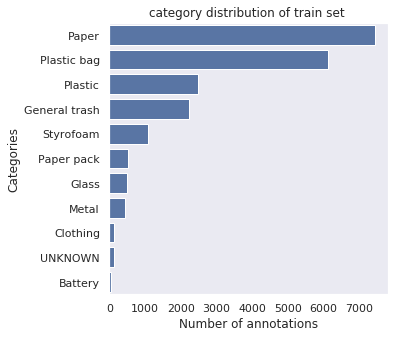

In [6]:
# Count annotations
cat_histogram = np.zeros(nr_cats,dtype=int)
for ann in anns:
    cat_histogram[ann['category_id']] += 1

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(5,5))

# Convert to DataFrame
df = pd.DataFrame({'Categories': cat_names, 'Number of annotations': cat_histogram})
df = df.sort_values('Number of annotations', 0, False)

# Plot the histogram
plt.title("category distribution of train set ")
plot_1 = sns.barplot(x="Number of annotations", y="Categories", data=df, label="Total", color="b")

In [7]:
# category labeling 
sorted_temp_df = df.sort_index()

# background = 0 에 해당되는 label 추가 후 기존들을 모두 label + 1 로 설정
sorted_df = pd.DataFrame(["Backgroud"], columns = ["Categories"])
sorted_df = sorted_df.append(sorted_temp_df, ignore_index=True)

In [8]:
# class (Categories) 에 따른 index 확인 (0~11 : 총 12개)
sorted_df

,Categories,Number of annotations
0,Backgroud,NaN
1,UNKNOWN,128.0
2,General trash,2225.0
3,Paper,7448.0
4,Paper pack,527.0
5,Metal,449.0
6,Glass,488.0
7,Plastic,2472.0
8,Styrofoam,1074.0
9,Plastic bag,6114.0


## 데이터 전처리 함수 정의 (Dataset)

In [9]:
category_names = list(sorted_df.Categories)

def get_classname(classID, cats):
    for i in range(len(cats)):
        if cats[i]['id']==classID:
            return cats[i]['name']
    return "None"

class CustomDataLoader(Dataset):
    """COCO format"""
    def __init__(self, data_dir, mode = 'train', transform = None):
        super().__init__()
        self.mode = mode
        self.transform = transform
        self.coco = COCO(data_dir)
        
    def __getitem__(self, index: int):
        # dataset이 index되어 list처럼 동작
        image_id = self.coco.getImgIds(imgIds=index)
        image_infos = self.coco.loadImgs(image_id)[0]
        
        # cv2 를 활용하여 image 불러오기
        images = cv2.imread(os.path.join(dataset_path, image_infos['file_name']))
        images = cv2.cvtColor(images, cv2.COLOR_BGR2RGB).astype(np.float32)
        images /= 255.0
        
        if (self.mode in ('train', 'val')):
            ann_ids = self.coco.getAnnIds(imgIds=image_infos['id'])
            anns = self.coco.loadAnns(ann_ids)

            # Load the categories in a variable
            cat_ids = self.coco.getCatIds()
            cats = self.coco.loadCats(cat_ids)

            # masks : size가 (height x width)인 2D
            # 각각의 pixel 값에는 "category id + 1" 할당
            # Background = 0
            masks = np.zeros((image_infos["height"], image_infos["width"]))
            # Unknown = 1, General trash = 2, ... , Cigarette = 11
            for i in range(len(anns)):
                className = get_classname(anns[i]['category_id'], cats)
                pixel_value = category_names.index(className)
                masks = np.maximum(self.coco.annToMask(anns[i])*pixel_value, masks)
            masks = masks.astype(np.float32)

            # transform -> albumentations 라이브러리 활용
            if self.transform is not None:
                transformed = self.transform(image=images, mask=masks)
                images = transformed["image"]
                masks = transformed["mask"]
            
            return images, masks, image_infos
        
        if self.mode == 'test':
            # transform -> albumentations 라이브러리 활용
            if self.transform is not None:
                transformed = self.transform(image=images)
                images = transformed["image"]
            
            return images, image_infos
    
    
    def __len__(self) -> int:
        # 전체 dataset의 size를 return
        return len(self.coco.getImgIds())

## Dataset 정의 및 DataLoader 할당

In [19]:
# train.json / validation.json / test.json 디렉토리 설정
train_path = dataset_path + '/train.json'
val_path = dataset_path + '/val.json'
test_path = dataset_path + '/test.json'

# collate_fn needs for batch
def collate_fn(batch):
    return tuple(zip(*batch))

train_transform = A.Compose([A.Resize(width=64, height=64),
                             A.HorizontalFlip(0.5),
                             A.VerticalFlip(0.5),
                             A.RandomRotate90(p=0.5),
                            ToTensorV2()
                            ])

val_transform = A.Compose([A.Resize(width=256, height=256),
                           ToTensorV2()
                          ])

test_transform = A.Compose([A.Resize(width=256, height=256),
                            ToTensorV2()
                           ])

# create own Dataset 1 (skip)
# validation set을 직접 나누고 싶은 경우
# random_split 사용하여 data set을 8:2 로 분할
# train_size = int(0.8*len(dataset))
# val_size = int(len(dataset)-train_size)
# dataset = CustomDataLoader(data_dir=train_path, mode='train', transform=transform)
# train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# create own Dataset 2
# train dataset
train_dataset = CustomDataLoader(data_dir=train_path, mode='train', transform=train_transform)

# validation dataset
val_dataset = CustomDataLoader(data_dir=val_path, mode='val', transform=val_transform)

# test dataset
test_dataset = CustomDataLoader(data_dir=test_path, mode='test', transform=test_transform)


# DataLoader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size,
                                           shuffle=True,
                                           num_workers=4,
                                           collate_fn=collate_fn)

val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                         batch_size=batch_size,
                                         shuffle=False,
                                         num_workers=4,
                                         collate_fn=collate_fn)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          num_workers=4,
                                          collate_fn=collate_fn)

loading annotations into memory...
Done (t=3.73s)
creating index...
index created!
loading annotations into memory...
Done (t=0.83s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


### 데이터 샘플 시각화 (Show example image and mask)

- `train_loader` 
- `val_loader` 
- `test_loader` 

image shape: [3, 256, 256]
mask shape:  [256, 256]
Unique values, category of transformed mask : 
 [{0, 'Backgroud'}, {2, 'General trash'}, {'Paper', 3}]


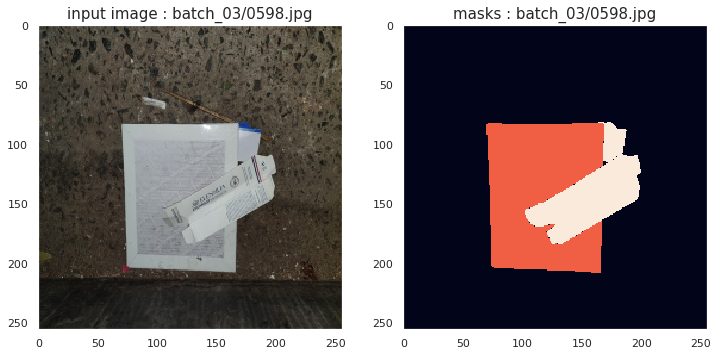

In [11]:
# train_loader의 output 결과(image 및 mask) 확인
for imgs, masks, image_infos in train_loader:
    image_infos = image_infos[0]
    temp_images = imgs
    temp_masks = masks
    
    break

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 12))

print('image shape:', list(temp_images[0].shape))
print('mask shape: ', list(temp_masks[0].shape))
print('Unique values, category of transformed mask : \n', [{int(i),category_names[int(i)]} for i in list(np.unique(temp_masks[0]))])

ax1.imshow(temp_images[0].permute([1,2,0]))
ax1.grid(False)
ax1.set_title("input image : {}".format(image_infos['file_name']), fontsize = 15)

ax2.imshow(temp_masks[0])
ax2.grid(False)
ax2.set_title("masks : {}".format(image_infos['file_name']), fontsize = 15)

plt.show()

image shape: [3, 256, 256]
mask shape:  [256, 256]
Unique values, category of transformed mask : 
 [{0, 'Backgroud'}, {'Glass', 6}, {'Plastic', 7}, {9, 'Plastic bag'}]


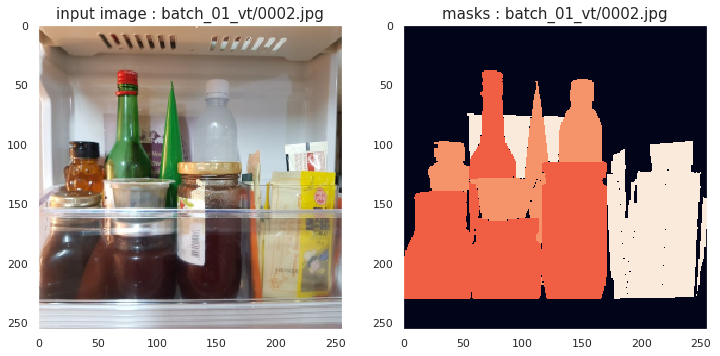

In [12]:
# val_loader의 output 결과(image 및 mask) 확인
for imgs, masks, image_infos in val_loader:
    image_infos = image_infos[0]
    temp_images = imgs
    temp_masks = masks
    
    break

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 12))

print('image shape:', list(temp_images[0].shape))
print('mask shape: ', list(temp_masks[0].shape))

print('Unique values, category of transformed mask : \n', [{int(i),category_names[int(i)]} for i in list(np.unique(temp_masks[0]))])

ax1.imshow(temp_images[0].permute([1,2,0]))
ax1.grid(False)
ax1.set_title("input image : {}".format(image_infos['file_name']), fontsize = 15)

ax2.imshow(temp_masks[0])
ax2.grid(False)
ax2.set_title("masks : {}".format(image_infos['file_name']), fontsize = 15)

plt.show()

image shape: [3, 256, 256]


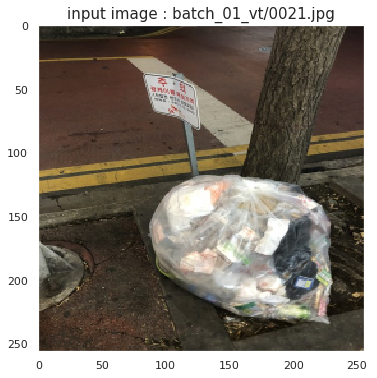

In [13]:
# test_loader의 output 결과(image) 확인
for imgs, image_infos in test_loader:
    image_infos = image_infos[0]
    temp_images = imgs
    
    break

fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))

print('image shape:', list(temp_images[0].shape))

ax1.imshow(temp_images[0].permute([1,2,0]))
ax1.grid(False)
ax1.set_title("input image : {}".format(image_infos['file_name']), fontsize = 15)

plt.show()

## baseline model

### FCN8s (VGG imageNet weight)

In [14]:
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torchvision.models import vgg16

class FCN8s(nn.Module):
    def __init__(self, num_classes):
        super(FCN8s,self).__init__()
        self.pretrained_model = vgg16(pretrained = True)
        features, classifiers = list(self.pretrained_model.features.children()), list(self.pretrained_model.classifier.children())

        self.features_map1 = nn.Sequential(*features[0:17])
        self.features_map2 = nn.Sequential(*features[17:24])
        self.features_map3 = nn.Sequential(*features[24:31])
        
        # Score pool3
        self.score_pool3_fr = nn.Conv2d(256, num_classes, 1)
        
        # Score pool4        
        self.score_pool4_fr = nn.Conv2d(512, num_classes, 1)        
        
        # fc6 ~ fc7
        self.conv = nn.Sequential(nn.Conv2d(512, 4096, kernel_size = 1),
                                  nn.ReLU(inplace=True),
                                  nn.Dropout(),
                                  nn.Conv2d(4096, 4096, kernel_size = 1),
                                  nn.ReLU(inplace=True),
                                  nn.Dropout()
                                  )
        
        # Score
        self.score_fr = nn.Conv2d(4096, num_classes, kernel_size = 1)
        
        # UpScore2 using deconv
        self.upscore2 = nn.ConvTranspose2d(num_classes,
                                           num_classes,
                                           kernel_size=4,
                                           stride=2,
                                           padding=1)
        
        # UpScore2_pool4 using deconv
        self.upscore2_pool4 = nn.ConvTranspose2d(num_classes, 
                                                 num_classes, 
                                                 kernel_size=4,
                                                 stride=2,
                                                 padding=1)
        
        # UpScore8 using deconv
        self.upscore8 = nn.ConvTranspose2d(num_classes, 
                                           num_classes,
                                           kernel_size=16,
                                           stride=8,
                                           padding=4)
    
    def forward(self, x):
        pool3 = h = self.features_map1(x)
        pool4 = h = self.features_map2(h)
        h = self.features_map3(h)
        
        h = self.conv(h)
        h = self.score_fr(h)
       
        score_pool3c = self.score_pool3_fr(pool3)    
        score_pool4c = self.score_pool4_fr(pool4)
        
        # Up Score I
        upscore2 = self.upscore2(h)
        
        # Sum I
        h = upscore2 + score_pool4c
        
        # Up Score II
        upscore2_pool4c = self.upscore2_pool4(h)
        
        # Sum II
        h = upscore2_pool4c + score_pool3c
        
        # Up Score III
        upscore8 = self.upscore8(h)
        
        return upscore8

In [15]:
# 구현된 model에 임의의 input을 넣어 output이 잘 나오는지 test

model = FCN8s(num_classes=12)
x = torch.randn([1, 3, 512, 512])
print("input shape : ", x.shape)
out = model(x).to(device)
print("output shape : ", out.size())

model = model.to(device)

input shape :  torch.Size([1, 3, 512, 512])
output shape :  torch.Size([1, 12, 512, 512])


## train, validation, test 함수 정의

In [12]:
def train(num_epochs, model, data_loader, val_loader, criterion, optimizer, saved_dir, val_every, device):
    print('Start training..')
    best_loss = 9999999
    for epoch in range(num_epochs):
        model.eval()
        for step, (images, masks, _) in enumerate(data_loader):
            images = torch.stack(images)       # (batch, channel, height, width)
            masks = torch.stack(masks).long()  # (batch, channel, height, width)
            
            # gpu 연산을 위해 device 할당
            images, masks = images.to(device), masks.to(device)
                  
            # inference
#             outputs = model(images)
#             # loss 계산 (cross entropy loss)
#             loss = criterion(outputs, masks)
            inputs = {'images': images, 'gts': masks}

            optimizer.zero_grad()
            outputs = model(inputs)['pred']
            #outputs = model(images)
            loss = criterion(outputs, masks)
            print(loss)
            loss.backward()
            optimizer.step()
            
            # step 주기에 따른 loss 출력
            if (step + 1) % 25 == 0:
                print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(
                    epoch+1, num_epochs, step+1, len(train_loader), loss.item()))
        
        # validation 주기에 따른 loss 출력 및 best model 저장
        if (epoch + 1) % val_every == 0:
            avrg_loss = validation(epoch + 1, model_2, val_loader, criterion, device)
            if avrg_loss < best_loss:
                print('Best performance at epoch: {}'.format(epoch + 1))
                print('Save model in', saved_dir)
                best_loss = avrg_loss
                save_model(model, saved_dir)

In [13]:
def validation(epoch, model, data_loader, criterion, device):
    print('Start validation #{}'.format(epoch))
    
    model.eval()
    with torch.no_grad():
        total_loss = 0
        cnt = 0
        mIoU_list = []
        for step, (images, masks, _) in enumerate(data_loader):
            
            images = torch.stack(images)       # (batch, channel, height, width)
            masks = torch.stack(masks).long()  # (batch, channel, height, width)

            images, masks = images.to(device), masks.to(device)            

            outputs = model(images)
            loss = criterion(outputs, masks)
            total_loss += loss
            cnt += 1
            
            outputs = torch.argmax(outputs.squeeze(), dim=1).detach().cpu().numpy()

            mIoU = label_accuracy_score(masks.detach().cpu().numpy(), outputs, n_class=12)[2]
            mIoU_list.append(mIoU)
            
        avrg_loss = total_loss / cnt
        print('Validation #{}  Average Loss: {:.4f}, mIoU: {:.4f}'.format(epoch, avrg_loss, np.mean(mIoU_list)))

    return avrg_loss

## 모델 저장 함수 정의

In [14]:
# 모델 저장 함수 정의
val_every = 1 

saved_dir = './saved'
if not os.path.isdir(saved_dir):                                                           
    os.mkdir(saved_dir)
    
def save_model(model, saved_dir, file_name='fcn8s_best_model(pretrained).pt'):
    check_point = {'net': model.state_dict()}
    output_path = os.path.join(saved_dir, file_name)
    torch.save(model.state_dict(), output_path)

## 모델 생성 및 Loss function, Optimizer 정의

In [16]:
# Loss function 정의
criterion = nn.CrossEntropyLoss()
model_2 = HRNet_Mscale(12, criterion)
model_2.to(device)
# Optimizer 정의
optimizer = torch.optim.Adam(params = model_2.parameters(), lr = learning_rate, weight_decay=1e-6)

In [20]:
train(num_epochs, model_2, train_loader, val_loader, criterion, optimizer, saved_dir, val_every, device)

Start training..
tensor(2.5197, device='cuda:0', grad_fn=<NllLoss2DBackward>)


RuntimeError: cuDNN error: CUDNN_STATUS_NOT_SUPPORTED. This error may appear if you passed in a non-contiguous input.

## 저장된 model 불러오기 (학습된 이후) 

In [ ]:
# best model 저장된 경로
model_path = './saved/fcn8s_best_model(pretrained).pt'

# best model 불러오기
checkpoint = torch.load(model_path, map_location=device)
model.load_state_dict(checkpoint)

# 추론을 실행하기 전에는 반드시 설정 (batch normalization, dropout 를 평가 모드로 설정)
# model.eval()

In [ ]:
# 첫번째 batch의 추론 결과 확인
for imgs, image_infos in test_loader:
    image_infos = image_infos
    temp_images = imgs
    
    model.eval()
    # inference
    outs = model(torch.stack(temp_images).to(device))
    oms = torch.argmax(outs.squeeze(), dim=1).detach().cpu().numpy()
    
    break

i = 3
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16, 16))

print('Shape of Original Image :', list(temp_images[i].shape))
print('Shape of Predicted : ', list(oms[i].shape))
print('Unique values, category of transformed mask : \n', [{int(i),category_names[int(i)]} for i in list(np.unique(oms[i]))])

# Original image
ax1.imshow(temp_images[i].permute([1,2,0]))
ax1.grid(False)
ax1.set_title("Original image : {}".format(image_infos[i]['file_name']), fontsize = 15)

# Predicted
ax2.imshow(oms[i])
ax2.grid(False)
ax2.set_title("Predicted : {}".format(image_infos[i]['file_name']), fontsize = 15)

plt.show()

## submission을 위한 test 함수 정의

In [ ]:
def test(model, data_loader, device):
    size = 256
    transform = A.Compose([A.Resize(256, 256)])
    print('Start prediction.')
    model.eval()
    
    file_name_list = []
    preds_array = np.empty((0, size*size), dtype=np.long)
    
    with torch.no_grad():
        for step, (imgs, image_infos) in enumerate(test_loader):

            # inference (512 x 512)
            outs = model(torch.stack(imgs).to(device))
            oms = torch.argmax(outs.squeeze(), dim=1).detach().cpu().numpy()
            
            # resize (256 x 256)
            temp_mask = []
            for img, mask in zip(np.stack(imgs), oms):
                transformed = transform(image=img, mask=mask)
                mask = transformed['mask']
                temp_mask.append(mask)

            oms = np.array(temp_mask)
            
            oms = oms.reshape([oms.shape[0], size*size]).astype(int)
            preds_array = np.vstack((preds_array, oms))
            
            file_name_list.append([i['file_name'] for i in image_infos])
    print("End prediction.")
    file_names = [y for x in file_name_list for y in x]
    
    return file_names, preds_array

## submission.csv 생성

In [ ]:
# sample_submisson.csv 열기
submission = pd.read_csv('./submission/sample_submission.csv', index_col=None)

# test set에 대한 prediction
file_names, preds = test(model, test_loader, device)

# PredictionString 대입
for file_name, string in zip(file_names, preds):
    submission = submission.append({"image_id" : file_name, "PredictionString" : ' '.join(str(e) for e in string.tolist())}, 
                                   ignore_index=True)

# submission.csv로 저장
submission.to_csv("./submission/Baseline_FCN8s(pretrained).csv", index=False)

## Reference



In [24]:


b = torch.randint(0,1,size=(1,3,256,256)).float()
c = torch.randint(0,1,size=(1,256,256)).long()
b = {'images':b, 'gts':c}
b = a(b)

NameError: name 'a' is not defined